# Introduction

This analysis aims to assess the solar energy potential in three locations—Benin-Malanville, Sierra Leone-Bumbuna, and Togo-Dapaong—by analyzing solar irradiance data over time. The goal is to identify the best location for solar installation, explore the impact of environmental factors on solar efficiency, and provide strategic recommendations based on statistical analysis and data visualizations.

## Key Variables:
- **GHI (Global Horizontal Irradiance)**: Solar radiation received on a horizontal surface.
- **DNI (Direct Normal Irradiance)**: Solar radiation received perpendicular to the sun’s rays.
- **DHI (Diffuse Horizontal Irradiance)**: Solar radiation received on a horizontal surface that does not come directly from the sun.

By analyzing these variables and others, I aim to identify optimal sites for solar panel installation and understand the factors affecting solar efficiency.

# **Data Import & Preparation**

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [2]:
files = {
    "Benin-Malanville": r'C:\Users\Eyor.G\Pictures\Projects\solar-site-optimizer\data\benin-malanville.csv',
    "SierraLeone-Bumbuna": r'C:\Users\Eyor.G\Pictures\Projects\solar-site-optimizer\data\sierraleone-bumbuna.csv',
    "Togo-Dapaong": r'C:\Users\Eyor.G\Pictures\Projects\solar-site-optimizer\data\togo-dapaong_qc.csv'
}

datasets = {name: pd.read_csv(file, parse_dates=["Timestamp"]) for name, file in files.items()}

# **Data Cleaning**

In [3]:
for name, df in datasets.items():
    df.drop("Comments", axis=1, inplace=True)
    df[['GHI','DHI','DNI']] = df[['GHI','DHI','DNI']].clip(lower=0)
    df.ffill(inplace=True)

# **Exploratory Data Analysis**

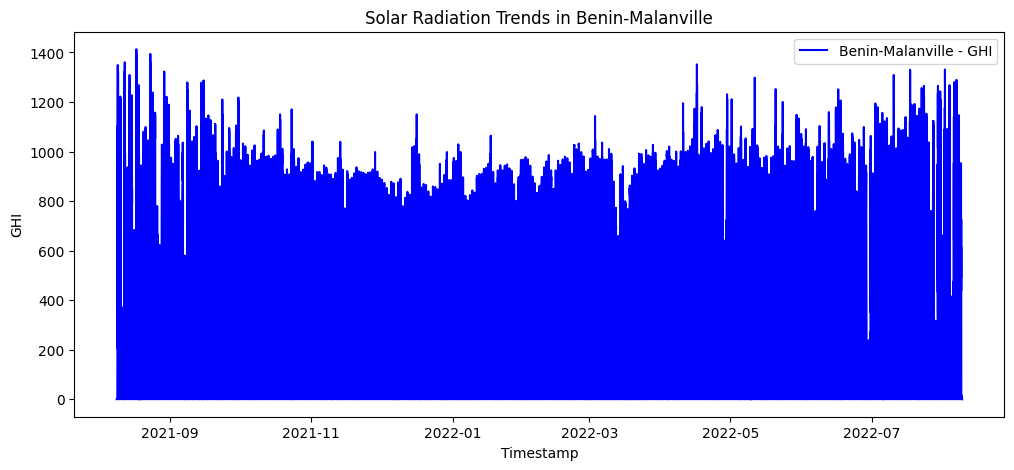

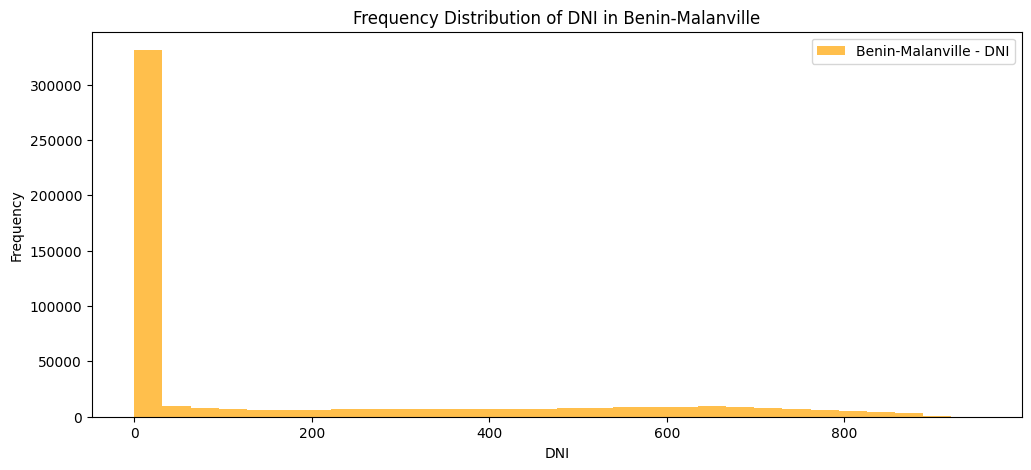

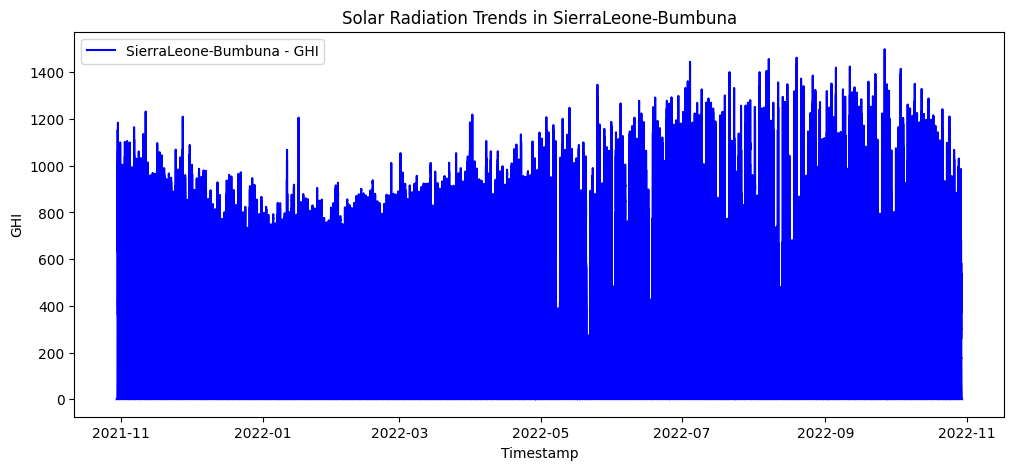

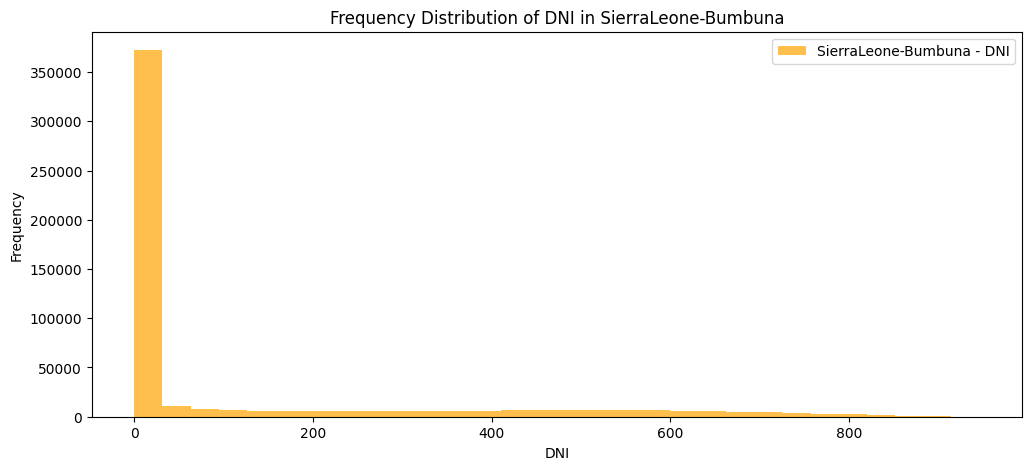

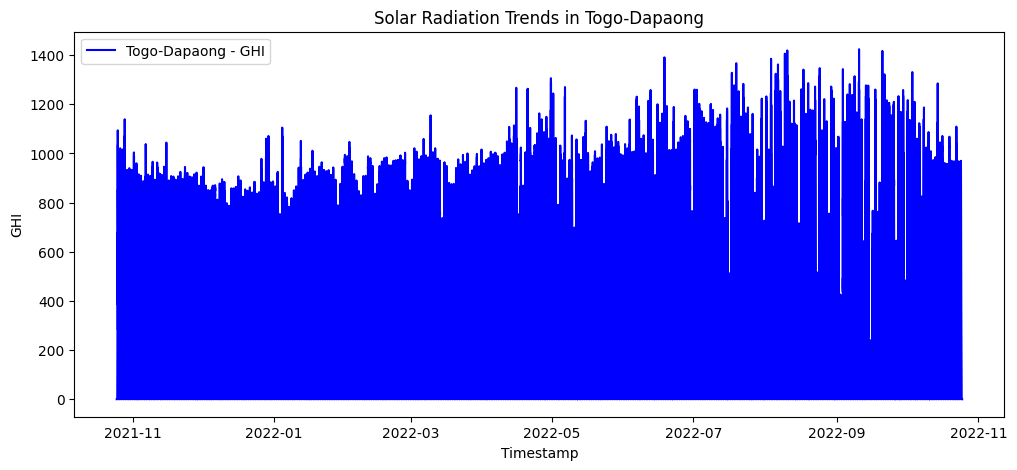

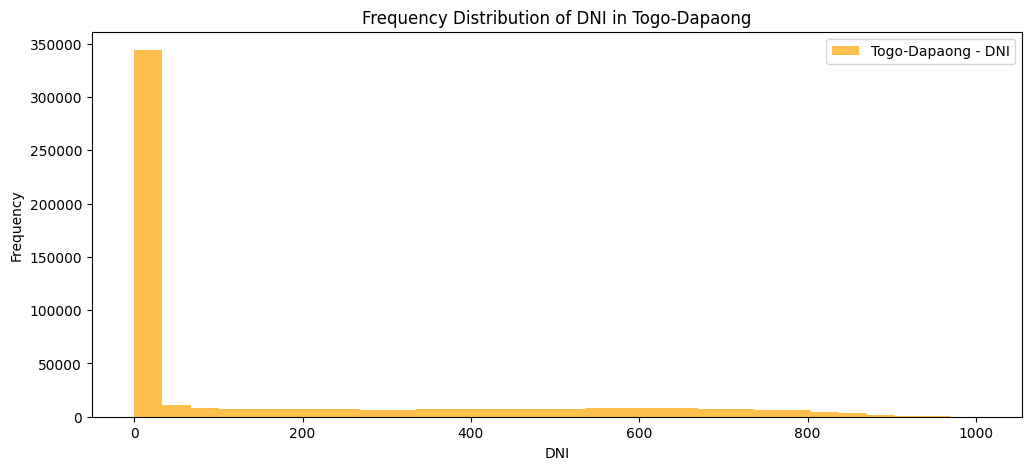

In [4]:
for name, df in datasets.items():
    plt.figure(figsize=(12,5))
    plt.plot(df['Timestamp'], df['GHI'], label=f"{name} - GHI", color = 'blue')
    plt.xlabel('Timestamp')
    plt.ylabel('GHI')
    plt.title(f"Solar Radiation Trends in {name}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.hist(df['DNI'], bins= 30, label=f"{name} - DNI", color = 'orange', alpha=0.7)
    plt.xlabel('DNI')
    plt.ylabel('Frequency')
    plt.title(f"Frequency Distribution of DNI in {name}")
    plt.legend()
    plt.show()

# **Hypothesis Testing (Comparing GHI across locations)**

In [5]:
benin, sierra, togo = [df['GHI'] for df in datasets.values()]
print("\nT-test Benin Vs. Sierra Leone:", ttest_ind(benin,sierra))
print("\nANOVA Test (GHI across all locations):", f_oneway(benin, sierra, togo))


T-test Benin Vs. Sierra Leone: TtestResult(statistic=np.float64(61.33000525104949), pvalue=np.float64(0.0), df=np.float64(1051198.0))

ANOVA Test (GHI across all locations): F_onewayResult(statistic=np.float64(1977.0703482755414), pvalue=np.float64(0.0))


# **Correlation Analysis**

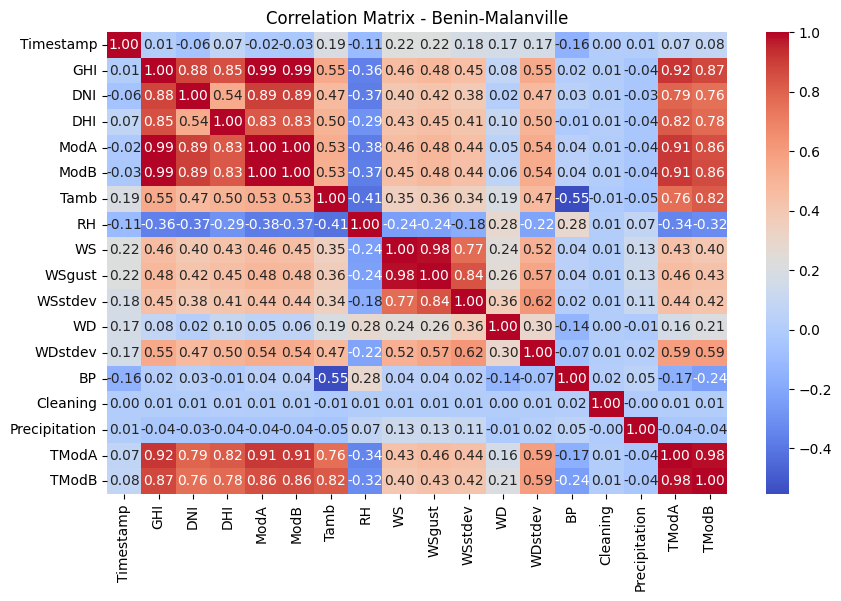

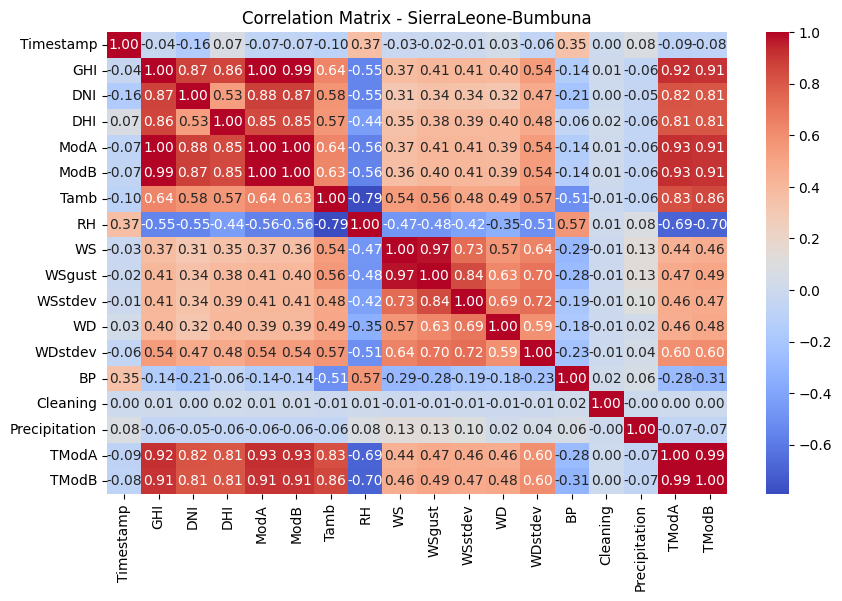

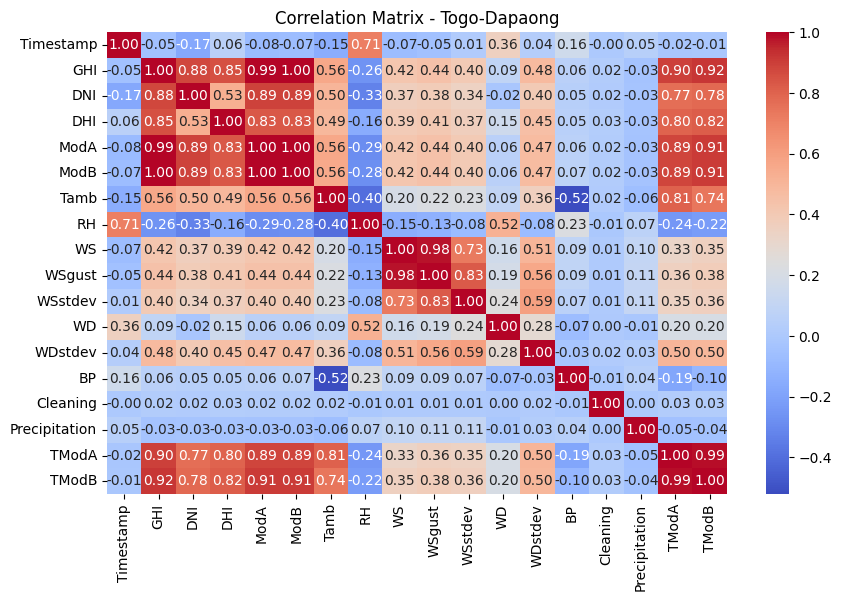

In [6]:
for name, df in datasets.items():
    corr_matrix = df.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation Matrix - {name}")
    plt.show()

# **Time Series Decomposition**

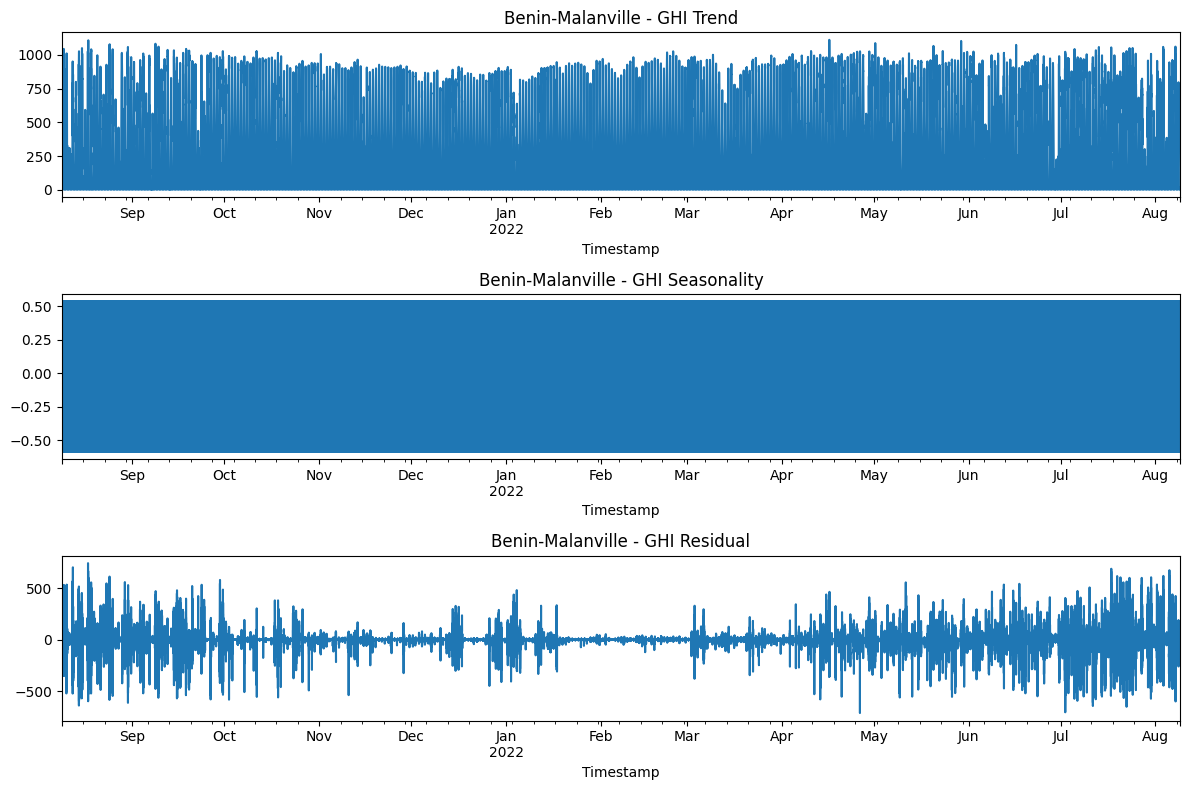

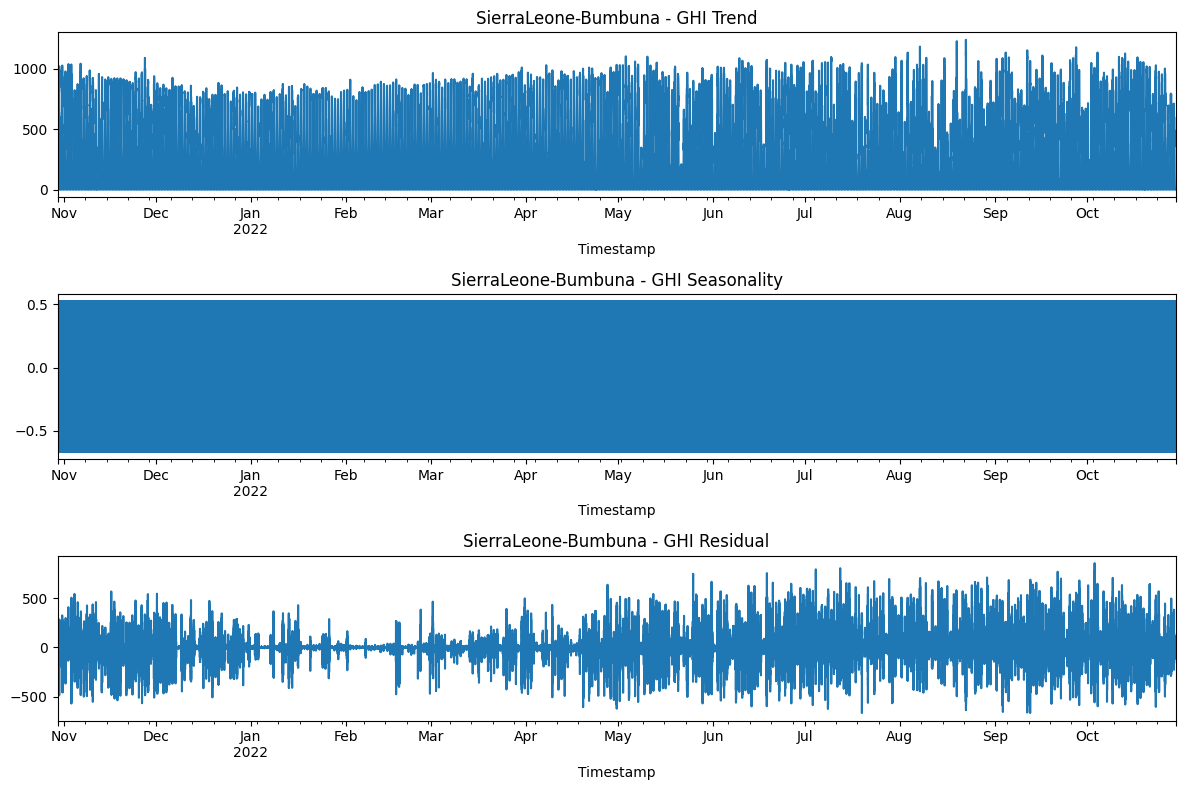

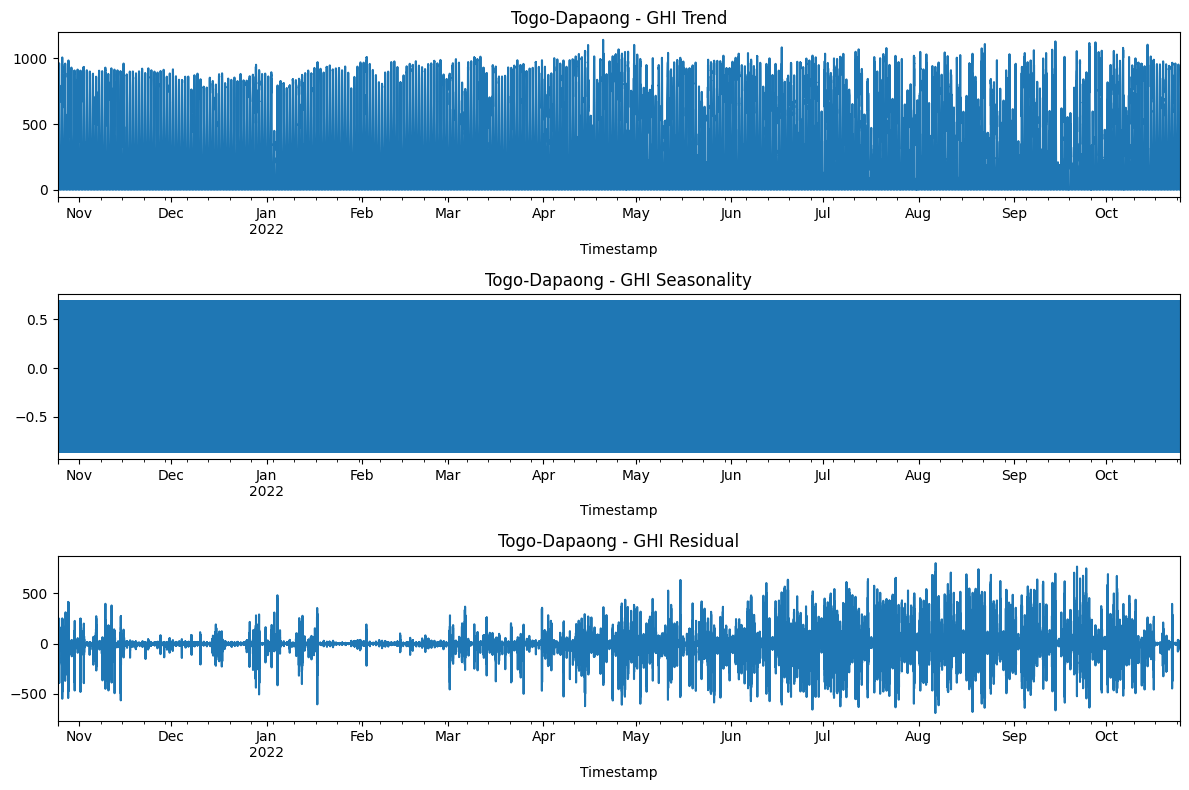

In [7]:
for name, df in datasets.items():
    decomposition = seasonal_decompose(df.set_index('Timestamp')['GHI'], model ='additive', period=24)
    fig, axes = plt.subplots(3,1,figsize=(12,8))
    decomposition.trend.plot(ax=axes[0], title=f'{name} - GHI Trend')
    decomposition.seasonal.plot(ax=axes[1], title=f'{name} - GHI Seasonality')
    decomposition.resid.plot(ax=axes[2], title=f'{name} - GHI Residual')
    plt.tight_layout()
    plt.show()

# **Ranking Best Location for Solar Investment**

In [8]:
ghi_avg = {name: df['GHI'].mean() for name, df in datasets.items()}
best_location = max(ghi_avg, key=ghi_avg.get)
print (f"\nBest Location for Solar Installation: {best_location} with Avg GHI of {ghi_avg[best_location]:.2f} W/m²")


Best Location for Solar Installation: Benin-Malanville with Avg GHI of 241.96 W/m²


# **Regression Analysis on Cleaning Impact**


Benin-Malanville - Cleaning Impact on ModA: Slope = 70.71, Intercept = 236.52


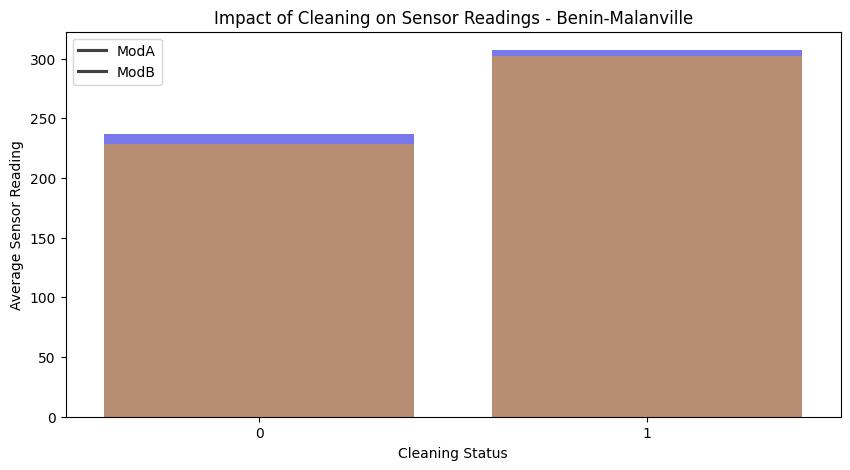


SierraLeone-Bumbuna - Cleaning Impact on ModA: Slope = 66.73, Intercept = 206.58


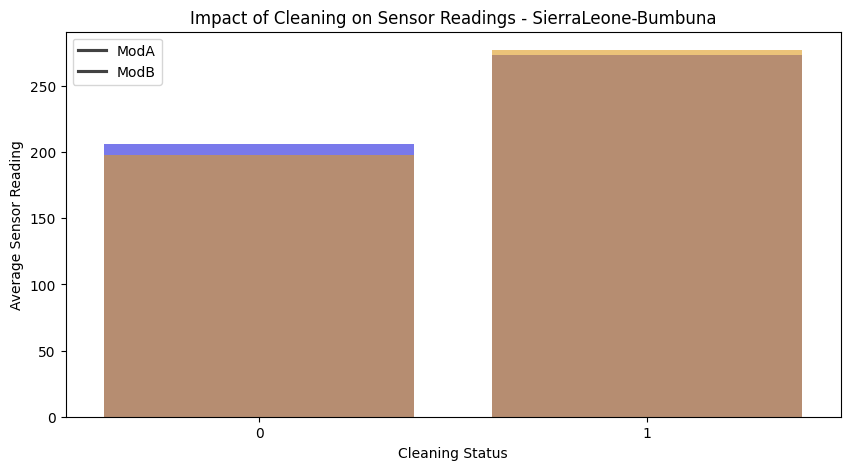


Togo-Dapaong - Cleaning Impact on ModA: Slope = 309.21, Intercept = 225.98


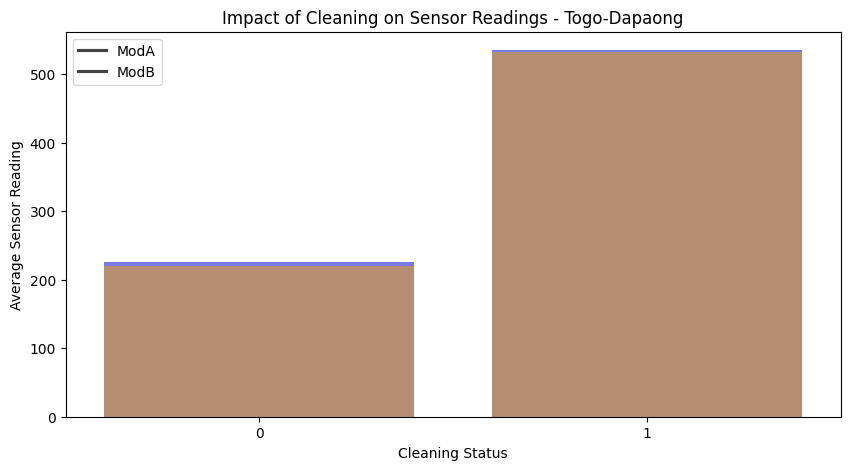

In [9]:
for name, df in datasets.items():
    if "Cleaning" in df.columns:
        df_cleaning = df.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
        X = df_cleaning['Cleaning'].values.reshape(-1, 1)  # Reshape to 2D
        y = df_cleaning['ModA']
        model = LinearRegression().fit(X, y)
        
        print(f"\n{name} - Cleaning Impact on ModA: Slope = {model.coef_[0]:.2f}, Intercept = {model.intercept_:.2f}")
        
        # Barplot for visualization
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Cleaning", y="ModA", data=df_cleaning, color="blue", alpha=0.6)
        sns.barplot(x="Cleaning", y="ModB", data=df_cleaning, color="orange", alpha=0.6)
        plt.title(f"Impact of Cleaning on Sensor Readings - {name}")
        plt.xlabel("Cleaning Status")
        plt.ylabel("Average Sensor Reading")
        plt.legend(["ModA", "ModB"])
        plt.show()

# **Time-Series Aggregation**

In [ ]:
for name, df in datasets.items():
    df['Date'] = df['Timestamp'].dt.date
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
# Aggregate daily data
daily_data = {}
for name, df in datasets.items():
    if 'Date' in df.columns:
        daily_data[name] = df.groupby('Date')[numeric_cols].mean().reset_index()
    else:
        print(f"'Date' column not found in dataset: {name}")

# Aggregate monthly data
monthly_data = {}
for name, df in datasets.items():
    if 'Timestamp' in df.columns:
        monthly_data[name] = df.resample('ME', on='Timestamp')[numeric_cols].mean().reset_index()
    else:
        print(f"'Timestamp' column not found in dataset: {name}")


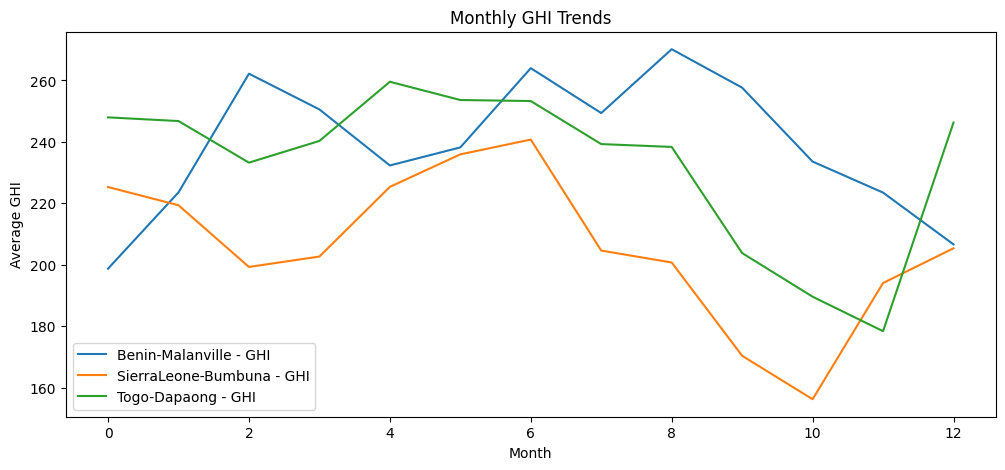

In [17]:
plt.figure(figsize=(12,5))
for name, df in monthly_data.items():
    plt.plot(df.index, df['GHI'], label=f"{name} - GHI")
plt.xlabel('Month')
plt.ylabel('Average GHI')
plt.title('Monthly GHI Trends')
plt.legend()
plt.show()

# **Solar Efficiency Analysis**

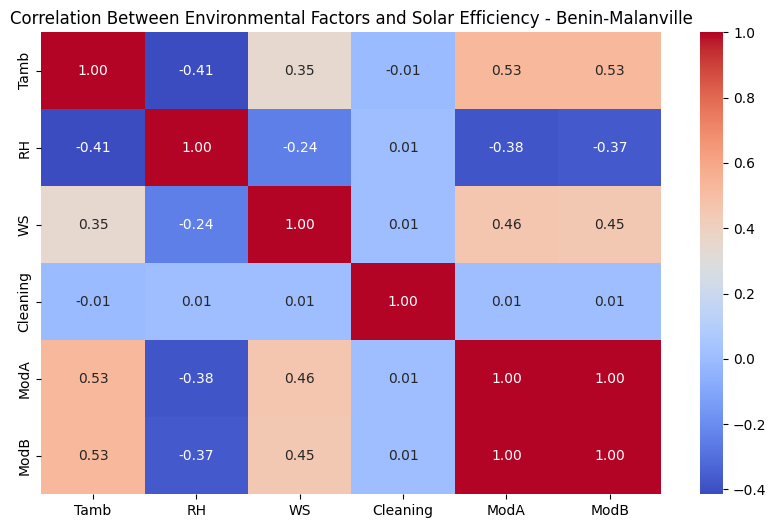

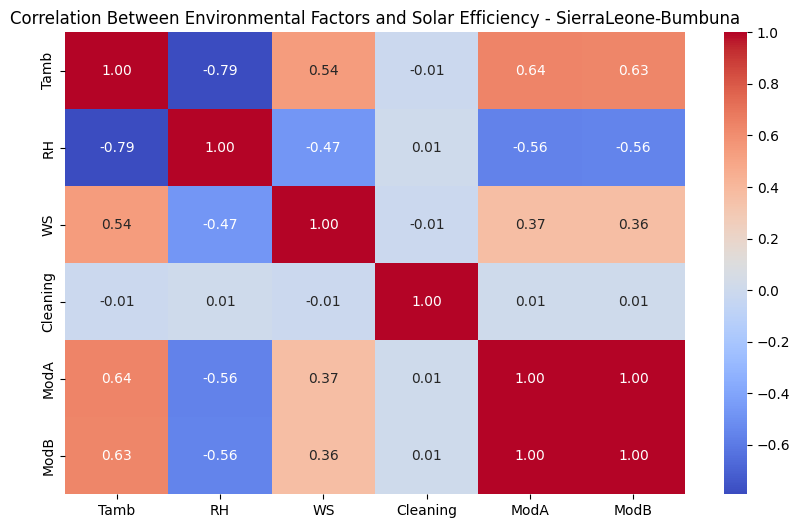

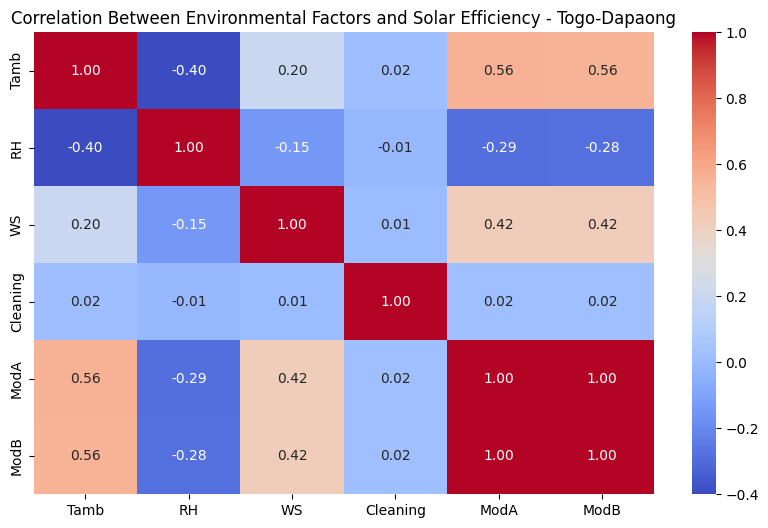

In [18]:
for name, df in datasets.items():
    correlation_matrix = df[["Tamb", "RH", "WS", "Cleaning", "ModA", "ModB"]].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Between Environmental Factors and Solar Efficiency - {name}")
    plt.show()

# **Strategic Recommendations**

In [ ]:
strategic_recommendations= []
if best_location=='Benin-Malanville':
    strategic_recommendations.append("Benin-Malanville is the optimal site for installation due to high GHI levels.")
if ghi_avg['Togo-Dapaong'] > ghi_avg['SierraLeone-Bumbuna']:
    strategic_recommendations.append("Togo-Dapaong also presents a viable option for solar investement.")
if any(df['WS'].mean() > 3 for df in datasets.values()):
    strategic_recommendations.append("Consider hybrid solar-wind installations for area with high wind speeds.")
cleaning_frequency = {
    name: (df['Cleaning'].sum() / len(df)) * 100  # Percentage of cleaning occurrences
    for name, df in datasets.items()
}
if any(freq > 50 for freq in cleaning_frequency.values()):  # Threshold: cleaning > 50% of the time
    strategic_recommendations.append("Regular cleaning of solar panels can significantly improve efficiency.")
    
print ("\nStrategic Recommendations:")
for rec in strategic_recommendations:
    print(f"- {rec}")


Strategic Recommendations:
- Benin-Malanville is the optimal site for installation due to high GHI levels.
- Togo-Dapaong also presents a viable option for solar investement.
